# Oxford Nanopore Techonology Pore simulator

#### **Author:** Adriano Fonzino, Ph.D.
#### **Date:** 2020/03/05

**Oxford Nanopore Technolgies** (**ONT**) is a **long-read sequencing** instrument that allows for the sequencing of **DNA** and **RNA** molecules. It's based on a nanometric protein **pore** that translocates nucleotide chains through it in order to obtain the nucleotidic sequence. This is possible because across the two side of the pore it is applied a constant voltage and thus the passage of nucleotides changes the value of the current flowing through the pore. The alteration type depends on the type of **nucleotide** passed through the pore. The recording of the **current perturbations** along time, during the translocation of the single strand DNA or RNA molecules gives information about the nucleotidic sequence of the strain. It seems to be an easy task but, in reality, there are a lot of problems with the analysis of the signals (a.k.a. ‘squiggle’ because of the typical shape of the signal). Each signal comes from a single DNA/RNA molecules, so it's really noisy and stochastic. More important, the electrical signal (and its resistance) depends on the several basis present inside the pore at each moment. It's not due only to a single base, but the current perturbation derives from the integration of the perturbation caused by the presence of at least 5 nucleotides into the pore (for instance, the R9.4 pore). Thus, it's important to be able to decrypt this signal using for example, **machine/deep learning algorithms**. If we considers the 4 classic bases we have $4^5 = 1024$ possible combination inside a pore. If we also considers **modified bases** like **m6A**, **m1A**, **Pseudouridin**, **Inosine**, **5mC** and others, the possibities increase drammatically (including them sequentially the combinations are 3125, 7776, 16807, 32768, 59049 and so on, respectively). The training of a several prototypes of LSTM and Bidirectional-LSTM AutoEncoders on the "EpiNano Curlcake" dataset, able to detect putative anomalies in ONT reads containing m6A modified bases, gave back bad results. Even if the model was able in some cases, to detect more anomalies in m6A-reads with respect the unmodified ones, these are too few. This behaviour is in line with the results of Liu et al., 2019, where in the SVM of the EpiNano algorithm they found that currents didn't contributed to the inference of modified bases. They were able to detect modified bases using the reference sequences and the mismatch, indels produced by aligning the Albacore basecalled fastq sequences with the reference "curcake" sequences. An explaination could be that in reality, the alterations to the signal due to m6A modifications is neglectable with respect the other unmodified bases counterparts or (that could be the case) are different from the canonical A bases but similar to other unmodified base. This means that, probably, the m6A signals are hidden as other normal signals and are called by the basecaller as an other normal base or absence of it.

Here I'll try to write a **computational implementation** of the pore, simulating the passage of an RNA strand that generates a signal depending on the combination of the 5 nucleotides inside the pore, at each moment. I considered that the instrument is able to read about 70 bases/second, with a sample frequency of about 4000 Hz. I added random noise to both duration time of each stride and to current signal amplitude to simulate random errors.
I'm going to use this in-silico "pore" to perform two parallel experiments using as starting point, the 10kb long curlcake sequence used in EpiNano, to produce in-silico signals.

1. **Experiment [1]:**
> I will use an implementation of the pore (Pore_1) where the m6A modified base produce a signal different from the canonical A, but similar to one of C, G, T/U.
    
2. **Experiment [2]:**
> I will use an implementation of the pore (Pore_2) where the m6A modified base produce a signal different from all the 4 canonical bases.


For each experiment I'll produce a dataset simulating raw signals of reads with and without the presence of m6A bases.
To do this I'll use two pore instances with two different conversion dictionaries.
Then I'll train a Long Short-Term Memory Auto Encoder (LSTM-AE) on unmodified reads to understand if my hypothesis are true, that is, the algorithm will not be able to detect more anomalies in m6A reads with respect unmodified reads generated by the NanoPore Model [1]  while, as the opposite, in sequences from NanoPore Model [2] it will be able to do this.

In [1]:
!pip install ont_fast5_api

## 1.0. Generation of the curlcake sequences

In [2]:
# importing basic modules
import os
from datetime import datetime
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from tqdm import tqdm
from ont_fast5_api.fast5_interface import get_fast5_file
from ont_custom_functions import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
import keras
from keras.layers import Input, Dropout, LSTM, RepeatVector, TimeDistributed, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
# load the 10 kb culcake sequence and generate the modified version with "a" instead of "A"
unmod_curlcake = "ATCATAATTAATACGACTCACTATAGGGAGATCCGGCTGTGGAAGTCGATGAATCAAAAACCTTGGACCCTATCTCACAACGAACGAGTAATCCTGCGTGGGACTACAAAGTCGTTTTCGTGGACCAGGCCTCGACCTCCCAAGCATATGGGGACGTCGCTCAAATCCACAGTAGACTATCTATTAACTAATTGTGGATCGATGCTGACGCTACCCAGGTCTAGTTCGAGCCAATAATGTGCTACGTCGCGAAAGCCAAACAACGCTAACACCCTATCGTTCATTTGATACGTAACATCAATCACCTTGCAACTAGCTCGAACGGTATGGTTCAACGAGGGTGTTAGGCAGCGAACAACCCAGAGCGTTTATCATACCATATGCTCAACATACTTCCAGAGAGTCTGTTGGTCTAACAAGGTATAGCGGCGAGCAACGGAAAAGATAGTGCGTAATAGTTCGAGGAGCACCGCATCCCCCTCGCCGTTTTCGGGCCGTTAATATGGGCCGTAACACACCGGAGTTTCATAAAACGGCCTTTCCGTTGCTCGGGTGAGGGCATACGTGCTGCCTGGAGGGTATCCTACATGGTTAAATGCTGCGCCCCGTTAGGAAGCAGCAAATAAGAGTCTACCCGGTCTACCGGTACAAAGTTCGTGAGAGTTCTTCATGCTCGTCTCATAAAGGACTGGCAAAGGCCTTTGTTGCGTCAATGAGGAAGCCAAGCGGCGAGGTCAAGGCCACGAGTACATGGGCCATTCTCCAGTATAGTGAAATAAGCCCACGCGGTAAACCAAATGTGGAGCACACTCCACGTTCCTGTTCGTGGGCCTATTGGGATATGTCTTTATCAGACAACCTTATTTACGCGTATACATGCGGCAGTAGGCCTCGCGGTCCTAAGGGTCAGGTGTTACCACTTACCTCAATTTTCTCTGGAGTAGTACTTAGACTACCATCTTTGTTGAGAAATCATCTCACCTCTCTAGTCAGGGATAGCGTCCACTGTCTAATTATACAACTATTCGATCAAGGTCGCAAGTGGATACTGAAAATCACTATGTAGAGCTTCGGAAAGCCTGAATTTTAAGTTATATCCTAAGAGCAGTGAACATTTCCAGCGATTTCCGTAGTTGCAATGTCAAACCCCGATCTAGGGTTAGAGTGCCTAGGTGCTATCCACGTGGTGTCCCTGGGAGGCTACCCTTCGTGGACATAACTCGGCAGACACTAGTCCGATCGCCAGGACAAAAATCAGCGACGAACCGGTCGAATCTTAAGCGAAATAGACGAGAAGTTTAGGCATGTTAAAGCGGGTGCCCGGCACTGGCGCGAGTAACGTTCCCTCCTCCATATCTATACACCAACCCCGAACCAGGAAGTGGGACTGGAGAGGTTTGGGTATCTTCAAAATTGTGCATTACTGTTGGAAAGGTTGGATGCTTCGCGCAATATCGATACCGATCTACTTGCGGTGAGCGCAAATTCGCGTAGCAAATAGTGACCCATCGCGGCCATCAATGCTGACAGGGAGCACAACCAGATCACGATAACTTGTAAAGGGGGTATAGCAGCTCACCGGAGGGAAATACTGCAATCATGGAGTCGTAAAACAGGGCCATGTCAACATCGTACGCGTTCGTCATTCTAGGTATTTATTCAAGGGGATAGAAGCGTGGAGTTATTGAATCCAAACCCAAGCCGCTGCAGCGAGGGCTACCACCCACGAGATCGGATGGTAGGGGGCGCCCGTGGGTAGGGGCCCTGGGTTATCACAAAAAGATCGCACTCTTCCTGGGCTTATGCGATACATCACCGGGAAATGATGCCACGTACCAGGATCGTTACGGGACCACGTCGAAGGCGCAGCAGCGAAGTGTGCTCTAGTATGTTTGTGAGTAGCACGGGTCGACGTTTATGCGTTCTCTTTCCTCCTAGATGGCAGCCTCCCCAATGATGGGAAGGACTTTTATCGACATGTGAACCGGCCCTAACGAGACAGGTCTTGGTCTTGGTATCGAGCAAGTATAACCAATTTCTTCACTCGCAGAAAAATGTTGACGAGGAGCAATTCTCTATTAACGCACGGTCTGCTATTTCGGGCCGGAGTCAAAGCTCGTATATCGTGACCTCTTGGGGATCGTGTCCCCGCTTGTGAATGTAGGCTCGCGGCCAACCCTCGTTACTATACGACGGGAGTGGGGAGTACGACATCAATAAAATAAGCAAAACAGCTCAAGATGCGACCTAGCCAATGATTTTAGGCGATCATTGGAATCATAATTAATACGACTCACTATAGGGAGACAGAAGCGGATTATGGGGGCGCCATTATCGCGCGCGTGCTACCCTGAATGATACAGAGCGTGTGTCCACGTCGAGCTGTTGCGTAAGTCGTCAGCATACGTCCCTTGGACCGTGCATATTCCTCAGTCACTACTTTCTAGACTCAATATCTTTCGATGCTCCCGTCGATCAAGTAACTCGCTGTCTCGCTCTGTGAGAGCAATAGCGCCTCGAGCTAAATGCCGACGCAAGGGGAATCATAGGAAAAGCCAGCAAAGCCCCTAAAAAAACGAGCATGGCTGTCATCGCTTGGGAGATTCGGGACTTAACAACGTCAGGCTAAGGGTAAAGGTTGGCCGTGTTAACCAGTTGCTCGGTCATGTCTCCGCTACCTGTGATCATATCGAAAACATAATAGCTAACTTGCCCGCAGATGGGCCGTGTGAAGCTGGTAGCCGACCCCACGGCCTTACCGGACACGCCCGGACCCCCGACACTCGTAGTAAAATTGATACATCGCGTTAATCGTGGGGCTGGCGCGTGCGACGGTTCTTGACATGTGTGGGTTATGTAAGTATAACAACCCTTGCGGCGTTGGCACGGCCCTAAGCTGAGAAAAAAGGTGCTCATAACTCAAACTTCGACGTTCCCCGTGGGTGGCGATAGGCATTGGTATGGTTTGGTCTTCTGCAAGTCGCCCAGGATGTGATCAATGTAACGAAAAGGAATGATAGTAAAAAGATCCGGCTGTGGAAGTCGATGAATCAAAAATCTTGGACCCTATCTCACAACGAACGAGTAATCCTGCGTGGGACTACAAAGTCATTTTCGTGGACGAGCCCTCGACCTCCCAAGCATATGGGGACGTCGCTCAAACCCACAGTAGACTATCAACTAACTATTGTGGCTCGAAGCTGACGCTACCCAAATCAGGTTCGAGCAAATAATGTGCTACGTCTCGAGAAACAACCCGAACACCCTGTCGTTCATTGGATACGTAACATCAATCACCTTGCAACTGCTCGCGGTATGGTTCAACGTGGTTGTTAGGCAGCGAACCACCCGGAGCGTTTATCACGCCATATCCTTAACAAGCCTCCAGAGAGTCTGTTGGTCTAACACTGTATAGCGGCGAGCGACGGAAAAGGTAGTGCGTAAAAGTGGATTAGCACCGCATCCCCCTCTCCGTTTTCTGGCCGTTAATATGTGTCGGAACAGACCGGATTTCATCACACGGCCTTTCCGTGCTGGGGTGAGGGCATACGAGATGCCTGGAGGGTATACTACTTGGGTAAATGCTGCGACCCGTAGGAAGCGGAATAAAATGTCCCCGGTCTCATGTACAATGTTCGCGCGAGTGCTCTATGCTCAGCTCATCCGTCACTGACTAAAGCCATTGCTGAGTCCATGAGGTAATAACGCGGCTCCGACAAGTCCCTAATAGTGTGCGCTTCTCCTGAATTGTCAAATGAGCCGACGATGTATTCCAAAGGCGGAGGCCACTCCACGTTCCTGTACGTTGGGGGATTGGGATATGCATTTCTTAGACCTGCTATTATACGCGTATAAACGCCCGTCGAGGTCGCGTTACTAATGGTGAAGTGATACCACACACCTAACGTCCAGCAGTATTTAGATACAAGATATTTGAGAACTCATTAACTCCTCTGGTCAGGGATGCTTCCACTGGACTCTAAGACTGTTTGATCAAGGTGGCCTATAGTTACGAATAGCTCTGTAAAGAGCTTCGGATGGCCAGATTTATTAGGTACACCATAGGACCAGTGAACATATACCGCGACATCGGTAAGTGTAATGCCACGATCTAGGGTGTGAGCGCCTAGGTGCTTTCACCAGGTCTGGGAGAGCCTGCCCTTCGTAGTCAGAACCCTCAGACTTAGTCCGATCGCCAAGTAAACATGACGTAGCCCCGCCGAAACGTTATATAGGCTAGAAGTATATGAAGGTTAAAGGGTTCCCGGCACTGCCGAGTCAATTCCTCCTATTTTTCAAGAGGCTGAAGACAGGAACCTGGTTTGTAGATGGTCGACTAGCTTTTAAACTGAACTACCAGCTAGGAGGTTTAGCGTACGATAAATTTCGATTCCGGTTTCTCAAGTTGAGCTCCCCTGACAGTGGTGCCTCGGGACACAATACGGCAATCTGTGATTACAGGGTCCAACACAGCAACCAGACATGCTAGTAAGATTAAATATATCAGAGCGGGGGGCACGCAGCCAGCCTTCCCCAGTAACGACGTTTCAGGCCCACTTCGCTTTAGTACGGAGTCGTCGTACTTCTGAAAATAGAGTAGGCGAATCGAAATCCCACCAAGACGTGCCCGGGGCTACAGCCCAGAAATGGGTGGGGCGGCCCGACTTGAGGCACATGTTATCGCTATGAGTACCGAAGATGAGAGGATGACATACTTAATTGAGTGGGTTGACGGGCCATGGTAGGTCATAGACAAATTCTAATTGGAATCATAATTAATACGACTCACTATAGGGAGACGCAGAGTTAGTGGCGCTGGCATGTGGTAACCAAAACGGTCGTGATGATGCGTTCTCTTCCGAATTTGTCCTCATACAGAGGGAGCTAACCTTATTTCCAGTCTTAAGCGAGACTCGCAAGAAGGCATCGTTGCACACTAGATTGATTCAATGCAAAAGCAGACGAAAGGATAAGAGTGTCTTTCTATATTGCATCATGCCGTCTTCGAATGATCGGCTAATCTACACATAGCCGGCCGCGCCAGTTGTCTCTCTGCCAAACGATTATGTAGGGCTCTCGGCAGGATCACTTATCTGAGACGCGAAGTTCCATAATTTTAGGATTCGACGCAATTGGTACGCACGGGGTTTTGAATGTAACTGTCCGGACTGGTGGAGTGAGTTGCGTCAGTCGCACAAGGGCGCGGACCTTTTTGTTTCCTTTAACGGCGTCTACTATGGCGTGACCCCTTAGCCTAAACCATGCGCCCATGTCAGCGCTCTTGTGTGGGCAACGGACGCCGCCTCTACGCCTTACAACAGTTCAGCCGTACATAACAGCTGGAACGGGTACCTATGTTTAAGTAGTAGCTATCCAGGACTTTCGCCTGTGCAAGCGCATTGAAACTTGTCGAACTTCAGATAACCCCGTGGCAGTGCCGGGAACTGGCGACTGCGCGCACTCAACATTGTTGTACTGCACGTACCAATGAACCGTGAAAGTACAGTCCTGGGTCACCCCAACGCTTGTAAGGAAACCGACCACGGATCGAGTTCTTGATAATACTGTGTTCTAGAGGTGTATCTTCAAAGAAAGACCATCCAATAGGGAAAGCTTGCTTATGACTCAGTACTCCGCGGGATCTGGACCCTACATGGATGTGACTTCCTAGCGCGTGTCCACCGGCGGGTTAGAGCATTAGAAAAAACTCGTGCGGGCGATTTGCAGTCACATCTGCTTGGTTATTCGGCGCAGTTTACTCACGGTTCTGCGGATAGTCGGTTGCCATCTATCGTCATCTCCAAGGCCGATTGCGGCATTCGTCCCATTTGGGCGTTGATGGAGACCCATCGCATGGCTGCAGCTTAAAAACAACGGAGGATGATGCCGTAGGCTGTAGAATGCAAGCGCGAGCGATCGTGATCGCTACCGATCCAGTCTTCCATAGTTGGATTCTGCTAGTAGTAGCGTAGCGGATAATATGCGGCACGTGCAGCGTGGGCGTGAAAATCATCGAGGATGTGTGGATCTAGTTGGGACGTTGACTCCAGCTTATGAGAGGAATATTAGTAGCAATAAAGCGCGCGCGGGCAACCGGAACAAGGCCTGCCGTGGTCGTATCGAGTCCAGGGGGTACGGACTGAGTGCGGTTAAGAACTGTCGTCTTAACCACGTATCTCCTCCTAGATCCTATTTTGTAAATTAGTGATTGCGCTACGGACCCTTACAACCTGAAAGAGGTGTTAGGGATATGAGATAATCGAACTGATCTCGGGCGTCCCGCTAGCCCGGTTTCGTACCGGGTTTGTTGACTTATGTCCATTGTACTTCAACGGTATCCCACTACGACGTAGCGACATCTGTTTGGTATGGCATCACTTGATCCAGCTGGTTCTGGGTATGCTCGACTCCGAAATGTTGACTGGGAATGAATGGTTTAGTAGGTTTGTCTGCGAACCCAGATGGCTTGCAAGCACTGCGCAGCCGAAGACAATGTACCGTAGACAGACTGACGCACACCAAAGATTTTGCTCACTCGTGGCTTTGAATTCGCGAGGACCGGGTAACAGCGGGACGGAGGCGACGGGCCCTGTCGACGACGAGCTGCCGACTAAGGGCTCACTTTACTTTCAGGGACTCGATAATGGTTCCCTTAAGCGTCTAAGTAGCCCGTACAGTCTGCGCCCTTGCTCCACTTGGTTTCTGGATGCCCTTTACGCGGGACGTCCAGATGCCACTCGGTGACGAAGAGTTTGGCGAATGACATACGTTGCGTTTGATTAAGGCATCGCTCGCTTGTCTCAGTGCTGAAGGACCTACCACCCTCAAGATCTCCTAATACACAAGACTCAGCGCAAAGGTCCGGTTGCTGCTCCCCTTTCACCCGGTCCCCTCGTGGCATAAGGTTGTCGACCGCCCTTGGTTTAATAATGGTCGCCACGTGAGCTTCTACCTTCCCCGAGAATGGGCTAACCCTAGCTGATACATCGCTGGGAGCGGGCTGCCGAGAAACTAAATCAGGGTTCATGGTGTCCGATTTGAAATCCGTGCTCCCTTAGCCTGCGGGAACGACCCGTAATGGCCGTTCTGGAGTTAGTTAACCAGACCAGCCGTCGCACTAATTTGCTCGCCGTTGACATTATGCAGAGAACAGAGGGCAGTACGCCAGGAATTGCGCCCGTCAACTTTTGAGCAATAATATGCCTACCTTATTATAGTCTAACAGAAGTACCTAGCGTGGTGGCAGACGGCCGATAGGCCTGTAAAGGCCATGGAGGCAGGTGTACCATCTACGGGAAGTATACGTTCGCGGAGAATACAATCTTAAATTTTCGTGGGGAATATCACATGGAACGTGTCACCATAAGCCATGGACTGTCCATGTCTATTAGGAATCATAATTAATACGACTCACTATAGGGAGACCGAGACTCTCGCCCCTCGAAGCGATCCACCCCGCATCCTAAACCCAGTCAAACTCCTGGACCGCGCTCCCTTGAGACTAGGCGATGCTCCCTCGCCGTGGTGTTTTCTCTAGCGGTATAGCGCTTCTGTCTTCCTATGGGCCGACTAGAATGACTGTCATCACTGGCATGGCATCAAGGGCCAACCTGCGTGGTCTGATTAGCTTGGTTAGGGGCTTGCCGATGTATTTAGCGCGCGTTTCGAAACAGCGGTTTCAACATTGGCCATAGCTACCTACGAATCCCTACGATTGATACACGGTCGGGACAAATGATCCGACCAAGGTGCCTCACTGGTGGGAAGTCTAGATTCATCCGTGGGACATCGGACAGTCCTCCGTTATGCGAACCTATGACTCCCACCCCAAAGGGCTAAACAAAGACATTCCCGTACGCGAGTAGAGGGAGCCTTAACCGCAGTGGGATGCTAGGATCGGCTAAGGGTTTCTCCTAATAGGCGGGAGTTTCTTTCAATGAATACATTGACTCCTCACCTGCGTAAGTTGCGAACCTGACGCTTGCGTGATAAATCCCAGGTTCGAACGCTAGGAGACGAGGCTGCTGCAGGCGGCTGCAGTTGGAAACCATGGATAAATTGCGCCACCGGGCTACTTAATGCCTGCGCTCCAGCCCTTTGAGTTTTTGCGCGCGATCCAGTAGAATCCTCCCCGTCGGAATTAGGCCTGTGGCGCGCGGTGCACCGAGAAATTAAACTGTGGCTCACAACGGCTAGGTTTTTCTGGAGCATAGCAGATTGCCTCATGTCCATCGGGCATACTGGTGATTGTCCCAGCGTCCTCAATTTTTTTAACGCTAAGCGAGTAATGCCATCGTGGCGAGTGAATGTCGGAGGTGGAACACTAACTAGGTTAGTGGCCGGCTCCCGGCCCAATTCGGACATGCTGTAACGTTAAGATTAGTAAGACAGCTGTCGTTCTAGCACATCGGCAAGGTTATAGTTTTTCGGTTGAATGCTCACGTCCCTAAGCGGCAGGAATAGTATAGCTTTGGGCTCTTCATGCGGAGATCACCTCATTCTGCTTCTAACTCAGGGGCCTACCACGGTACACCGCCACATGTCGAGACTTAGTCTTTTTGACGGCGGAACATCTCTCAGGCGTTCCAATCGGGCGATTAGAGCACCGAGCGTTACTTAGGATGGGTAACATTTGTATGACTAAGATCACTTGAAATAAATACAAGCGGGTACGTTCGAGACGAAACGTGTACATCAGGTCACGTCGTGCCGAAGCGTACCCTTCGTCCTGATGTCGCAACACTACAAGGTCTGCCGGAGCCTAAGTTAGTGCTAGACAAGCCATGCGCCGATAACTAAAGCAACGGTCGGTTTCCTCCAGTCACGTTCTACGTTACTCAGGATTTAGCATAGCCTAGAGACAGCAGCGAGTAGTATAATACAGCGTCGGCCGACCCCAGCTAAGGACCGTCTTCTTCGATATATGGCGCCCCAAGCTTCTGAACAGAGGGGATCTCGCTCGCCCCTATATGTTCTGGTACTTACTAAACGAAAAGACAGGGTTTTTGGAGTCAAGCCTAAACTGGTGCAATGACCCCTAGCTACTGAGGCCCTGACATTGGTTTGTAGAACTGCTCGGGTGTACCGTCCACAGGTACAGCAAATCACGTCACTTGAGAGCGGTCCCGTGCTGTGTTACGGCACAATAGGCACCTTTCGTTCAAAGCATTGAGAGACGTTCCCCGAGGCGACCGGGTCACGCAGAAGAGGTCGGTATTCGCAGCCAAAGCATAACCCGGTCCTCCTCAGAACAGCAGGACTCAAGCATAGGGACAGTGTTAGCCAGCCCAAGAAGGCAGCGGCGATTGCCGACCATCTTCCCTATAATGACAAGACCTTTCAGAGTGGACGTCTACTATGTCTTGGACTGCACGGGTGTCCTACGCATCGCGTGGGTCCAAGTCCCATTAGCAACTTCTCTCCCGTCGGTACAATGTTACAGTTAAGCAGCGCCTCTCAATCGAGAGGCTGCACGGGAGCTCGAGAGGCGGTATCGAGGGGGTAGGCCGTAAAATCGCTGACTCAAACGACTATAGGAGGCGTGTTGCATGTTTAATTAAAGCCATCGTCCAATTTTCATAGCTTAAGCTAACCCGGCCACCTTGAAGAAAAACAATTCCTTACGAATGTGGCACACTGTTCCATAGAGACAGGGGGGAGTTCCCTCCATAAATCACTGTTCGTATCCGAGGTCACTCGAATGGAGTGTACACTAAGCTTACGAGGGTGTACTGCACGCAATAAGTAACATAGCCTCCAATGTTGGATTGTGTTCTACCATGGTGTGGTATCAGTCGCTGCGCTGAGTGAGTCAAGAAATCGGGAGGTAAGTTTAGCGAAGTAAGTATTGCGCGTAGTCGACCCGGATGCCCACAATCATCCATCGACGACCCCTCTTTTACTTTATATCCTTGCCGTAGGCATGGTGAGGCCATTAGCGGGTAATCACCCTCTTAGTCCATCTCGCGCCATCGAATTTCATTATACTCCGCCTTGGAGACTTACATTAGCAGTCTACGCTCTCGTTGCGCGGTCCACTCACTACTATCTGACCACTCGCAAACATCGAACCTGCGGGTACACTGGTCAGCCAAACAGGATGCCGGACAGACAACCGAACAAGAGCATGTAGGGA"
m6A_curlcake = unmod_curlcake.replace("A", "a")
print("umodified-curlcake length:", len(unmod_curlcake), "bases")
print("m6A-curlcake length:", len(m6A_curlcake), "bases" )

umodified-curlcake length: 10135 bases
m6A-curlcake length: 10135 bases


In [4]:
# generate the 4 curlcakes sequences for both umodified and m6A-modified reads.
unmod_curlcakes = [unmod_curlcake[0:2530], unmod_curlcake[2530:5060], unmod_curlcake[5060:7590], unmod_curlcake[7590:]]
m6A_curlcakes = [m6A_curlcake[0:2530], m6A_curlcake[2530:5060], m6A_curlcake[5060:7590], m6A_curlcake[7590:]]
for i in range(4):
    print(f"unmodified-curlcake n° {i+1} length: {len(unmod_curlcakes[i])} bases")
print("")
for i in range(4):
    print(f"m6A-curlcake n° {i+1} length: {len(m6A_curlcakes[i])} bases" )

unmodified-curlcake n° 1 length: 2530 bases
unmodified-curlcake n° 2 length: 2530 bases
unmodified-curlcake n° 3 length: 2530 bases
unmodified-curlcake n° 4 length: 2545 bases

m6A-curlcake n° 1 length: 2530 bases
m6A-curlcake n° 2 length: 2530 bases
m6A-curlcake n° 3 length: 2530 bases
m6A-curlcake n° 4 length: 2545 bases


In [5]:
# defining criteria of conversion by two dictionaries for the two different experiments.
conv_dict_1 = {"G":60, "A":100, "T":80, "U":80, "C":120, "a":118}
conv_dict_2 = {"G":60, "A":100, "T":80, "U":80, "C":120, "a":170}

## 2.0. Implementation of the pore model

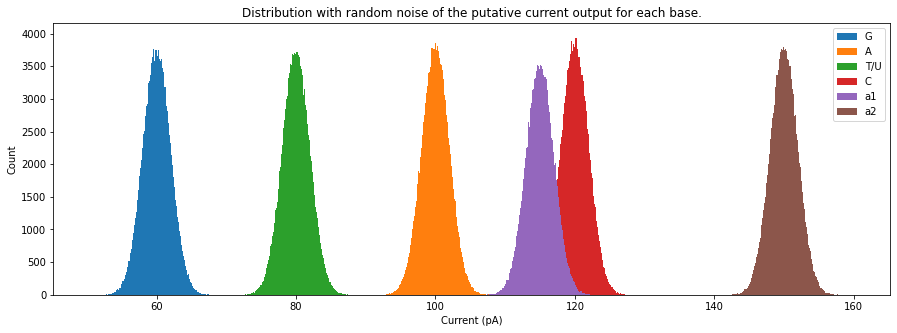

In [6]:
# brief analysis to find a good random noise value to be added to signal duration for each timestep
plt.figure(figsize=(15,5))
plt.hist(60 + np.random.normal(0, 2, 500000), bins=500, label="G")
plt.hist(100 + np.random.normal(0, 2, 500000), bins=500, label="A")
plt.hist(80 + np.random.normal(0, 2, 500000), bins=500, label="T/U")
plt.hist(120 + np.random.normal(0, 2, 500000), bins=500, label="C")
plt.hist(115 + np.random.normal(0, 2, 500000), bins=500, label="a1")
plt.hist(150 + np.random.normal(0, 2, 500000), bins=500, label="a2")
plt.title("Distribution with random noise of the putative current output for each base.")
plt.xlabel("Current (pA)")
plt.ylabel("Count")
plt.legend()
plt.show()

In [7]:
# define the class of the Pore
class Pore:
    '''
    A class that simulate in silico, in a simple manner a nanopore of ONT that
    takes in input a given sequence of nucleotides and a conversion_dictionary
    with the criteria of conversion from base to current. 
    As output the pore object generates a synthetic raw current signal as numpy array.
    '''
    def __init__(self, conversion_dictionary):
        '''
        Inizialize the model and the basic variables.
        '''
        self.conv_dict = conversion_dictionary
        self.pocket_dimension = 5
        self.pocket_weights = [1, 5, 10, 5, 1]
        
    def raw_from_seq(self, sequence):
        '''
        Method to generate from the nucleotidic sequence the raw current signal 
        with random noise added to both current and time_step duration.
        '''
        self.seq = sequence
        self.seq_time_steps = []
        self.raw_signal = []
        for i in range(len(self.seq)-self.pocket_dimension+1):
            self.seq_time_steps.append(self.seq[i:i+self.pocket_dimension])

        for kmer in self.seq_time_steps:
            self.kmer_conv = []
            for i in list(kmer):
                self.kmer_conv.append(self.conv_dict[i])
            self.kmer_conv = np.array(self.kmer_conv)
            self.kmer_signal = self.kmer_conv.dot(self.pocket_weights) / 22
            self.signal_duration = int(57 + np.random.normal(0, 2, 1))
            self.kmer_output = []
            for i in range(self.signal_duration):
                self.kmer_output.append(float(self.kmer_signal + np.random.normal(0, 2, 1)))
            self.raw_signal += self.kmer_output
        return self.raw_signal

In [8]:
# generate the two different instances of the pore with the two 
# conversion dictionaries.
pore1 = Pore(conv_dict_1)
pore2 = Pore(conv_dict_2)

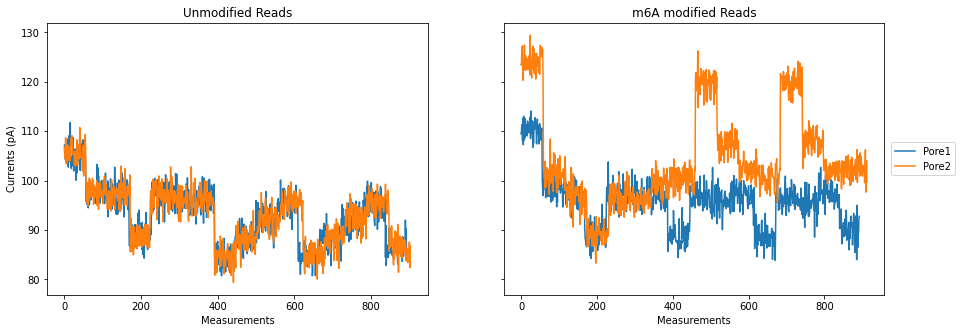

In [9]:
# plot an example of the diffence of signals generated in presence and absence of m6A bases by the two pore models.
unmod_sequence = "AACTCGCTCGATCGATCGAC"
mod_sequence = unmod_sequence.replace("A", "a")
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
axes[0].plot(pore1.raw_from_seq(unmod_sequence), label="Pore1")
axes[0].plot(pore2.raw_from_seq(unmod_sequence), label="Pore2")
axes[0].set_ylabel("Currents (pA)")
axes[0].set_xlabel("Measurements")
axes[0].set_title("Unmodified Reads")
axes[1].plot(pore1.raw_from_seq(mod_sequence), label="Pore1")
axes[1].plot(pore2.raw_from_seq(mod_sequence), label="Pore2")
axes[1].set_xlabel("Measurements")
axes[1].set_title("m6A modified Reads")
plt.legend(bbox_to_anchor=(1.2,0.5) , loc="right")
plt.show()

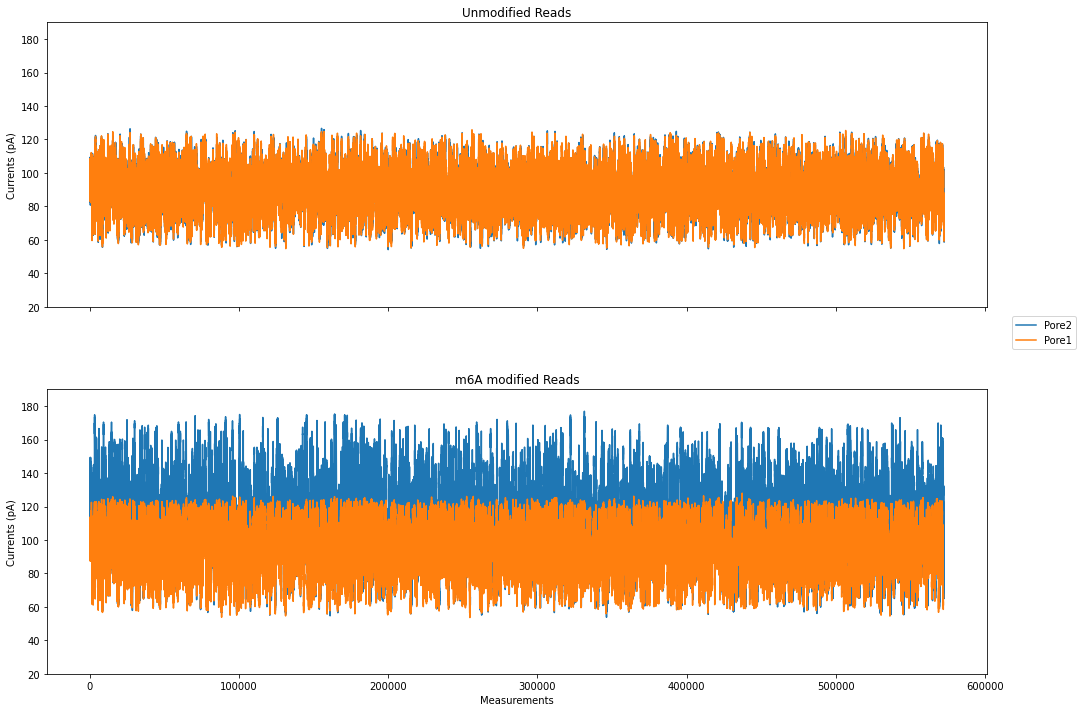

In [10]:
# plot the curcakes diffences in signals generated in 
# presence and absence of m6A bases by the two pore models.
pore1 = Pore(conv_dict_1)
pore2 = Pore(conv_dict_2)
fig, axes = plt.subplots(2, 1, figsize=(15,10), sharex=True)
axes[0].plot(pore2.raw_from_seq(unmod_curlcake), label="Pore2")
axes[0].plot(pore1.raw_from_seq(unmod_curlcake), label="Pore1")
axes[0].set_ylabel("Currents (pA)")
axes[0].set_title("Unmodified Reads")
axes[0].set_ylim((20, 190))
axes[1].plot(pore2.raw_from_seq(m6A_curlcake), label="Pore2")
axes[1].plot(pore1.raw_from_seq(m6A_curlcake), label="Pore1")
axes[1].set_xlabel("Measurements")
axes[1].set_ylabel("Currents (pA)")
axes[1].set_title("m6A modified Reads")
axes[1].set_ylim((20, 190))
axes[1].legend(bbox_to_anchor=(1.1, 1.2) , loc="right")
plt.tight_layout()
plt.show()

## 3.0. Generation of the datasets

In [11]:
# defining number of reads for both the pore models.
unmod_reads_n = 10
m6A_reads_n = int(unmod_reads_n * 0.5)

### 3.1. Generation of the dataset for the first experiment with the pore model [1]

In [12]:
# contains the generated signals. Each column is a read, while rows are ionic currents measurements
X_1 = {} 
# contain unmod/mod class (0: unmodified, 1: modified)
y_1 = []
# contain curlcake class (0, 1, 2, 3)
y_1_curlcake = []

# generate raw signals and y vector of classes for the unmodified reads with the pore [1]
with tqdm(total = (unmod_reads_n*len(unmod_curlcakes)) + (m6A_reads_n*len(m6A_curlcakes))) as pbar:
    for i in range(0, unmod_reads_n):
        for curlcake in range(4):
            unmod_gen_seq = pore1.raw_from_seq(unmod_curlcakes[curlcake])
            y_1.append(0)
            y_1_curlcake.append(curlcake)
            X_1[ curlcake + (len(unmod_curlcakes)*i) ] = unmod_gen_seq
            pbar.update(1)
    
      
    # generate raw signals and y vector of classes for the m6A modified reads with the pore [1] 
    for i in range(unmod_reads_n, unmod_reads_n + m6A_reads_n):
        for curlcake in range(4):         
            m6A_gen_seq = pore1.raw_from_seq(m6A_curlcakes[curlcake])
            y_1.append(1)
            y_1_curlcake.append(curlcake)
            X_1[ curlcake + (len(m6A_curlcakes)*i) ] = m6A_gen_seq
            pbar.update(1)

X_1 = pd.DataFrame.from_dict(X_1, orient='index')
X_1 = X_1.T

100%|██████████| 60/60 [00:48<00:00,  1.23it/s]


In [13]:
X_1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,106.057325,99.127198,88.178213,97.213788,101.299165,98.747690,87.925879,95.714246,103.942505,99.538960,84.639291,96.045802,101.752718,99.863293,86.979342,97.349671,103.195383,98.872108,82.241749,96.834773,109.908636,96.086375,89.734911,95.400041,103.382173,97.517590,87.363064,98.040625,104.308803,99.111401,86.264514,98.851712,102.805760,100.561774,84.950582,98.750483,100.960588,94.729023,87.164972,98.213841,106.268781,104.057873,93.433025,105.856481,108.893023,102.988737,91.525552,105.440308,109.309795,103.883187,95.289847,105.791017,110.163301,101.093343,93.726283,104.934478,107.066913,106.087000,95.026254,105.357169
1,105.338240,99.366623,85.308330,95.639475,102.233912,98.727762,88.720050,96.372607,106.118948,98.074809,87.731139,97.782317,104.647306,100.457461,83.254714,96.337846,101.756366,97.617566,87.564208,97.083670,103.900699,100.454418,87.864059,96.618257,104.123308,100.585246,86.028372,98.575056,105.435775,96.991921,85.290367,96.020307,101.608378,100.332451,87.492359,95.683120,101.104904,98.848840,83.865940,95.855802,107.704976,105.280674,94.953462,105.319516,107.934582,104.463535,95.839517,105.787808,109.332225,103.626370,96.556281,106.622779,108.122864,107.434077,93.280442,105.972339,108.978801,103.069821,95.737600,103.905040
2,103.678737,96.266850,89.075844,95.484412,101.717431,96.570796,87.220935,96.718968,103.127087,97.692389,88.038409,100.016145,102.548704,101.604768,87.775653,95.833770,104.849510,99.840423,85.718259,97.348217,102.879324,100.473653,84.546246,101.024341,107.378082,100.517755,87.079373,99.435589,103.619813,100.890238,89.915653,96.854309,103.839804,98.696471,88.877871,96.129664,102.005628,98.267981,91.290209,97.908633,109.253945,102.979370,95.920441,102.146031,108.230191,101.867651,95.555935,106.544922,106.550097,107.881290,94.757939,107.121714,108.757468,101.323463,94.847133,101.911610,109.385581,104.737875,97.788530,101.268748
3,106.175114,105.401053,87.410175,96.693680,103.537437,100.552554,84.140062,97.885549,100.266339,96.614636,86.248087,98.702160,99.859376,96.947133,87.501270,97.425463,104.126181,95.792737,90.139921,96.312476,103.276687,99.078462,86.129488,97.867242,101.924900,99.663636,84.637697,97.327141,101.715869,99.202759,86.973531,97.157299,101.707649,100.888068,86.724062,95.632781,102.220706,99.767758,84.823734,100.616711,106.780396,101.021009,95.525698,106.656503,109.743794,103.781398,96.094687,106.815507,111.356011,106.478288,94.169691,104.880668,108.157386,102.416053,95.402049,101.635446,107.856083,107.617780,95.729282,103.435413
4,105.682827,97.432207,87.385463,94.990521,105.175636,99.443703,90.990747,96.856327,105.747443,98.381529,88.284621,95.986917,104.933224,94.796583,86.100373,90.400652,105.398187,96.459502,86.012212,95.553456,101.743982,98.555802,87.461394,93.987098,104.607828,97.155661,83.490175,96.082803,103.480901,98.140306,86.873805,99.098408,104.908320,101.117808,84.520958,96.458194,102.354336,96.842428,88.176293,94.911703,105.802177,103.932180,95.074706,104.714204,108.996398,101.318474,91.638328,107.886648,106.860708,102.499126,92.738741,104.081033,107.766237,99.105827,95.099528,105.041127,107.510988,105.639744,94.070550,105.754881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.564110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.503818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [14]:
print(f"X_1 memory usage: {X_1.memory_usage().sum() / 1024 / 1024} Mb.")

X_1 memory usage: 65.79220581054688 Mb.


In [15]:
print("Proportion of unmod/mod classes in all the reads (NanoPore Model [1])")
print(np.unique(np.array( y_1 ), return_counts=True))

Proportion of unmod/mod classes in all the reads (NanoPore Model [1])
(array([0, 1]), array([40, 20]))


In [16]:
print("Curcakes Proportion in all the reads (NanoPore Model [1])")
print(np.unique(np.array( y_1_curlcake ), return_counts=True))

Curcakes Proportion in all the reads (NanoPore Model [1])
(array([0, 1, 2, 3]), array([15, 15, 15, 15]))


In [17]:
print("Curcakes Proportion in Unmodified Reads (NanoPore Model [1])")
print(np.unique(np.array( y_1_curlcake[:y_1.count(0)] ), return_counts=True))
print("Curcakes Proportion in m6A-modified Reads (NanoPore Model [1])")
print(np.unique(np.array( y_1_curlcake[y_1.count(0):] ), return_counts=True))

Curcakes Proportion in Unmodified Reads (NanoPore Model [1])
(array([0, 1, 2, 3]), array([10, 10, 10, 10]))
Curcakes Proportion in m6A-modified Reads (NanoPore Model [1])
(array([0, 1, 2, 3]), array([5, 5, 5, 5]))


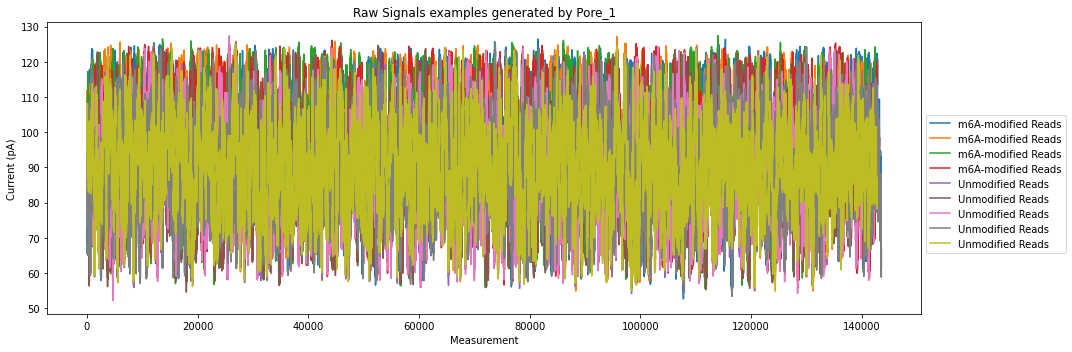

In [18]:
# show a subset of the dataset for the signals generated by the pore [1]
plt.figure(figsize=(15, 5))
plt.plot(X_1.iloc[:, -5:-1], label="m6A-modified Reads")
plt.plot(X_1.iloc[:, 0:5], label="Unmodified Reads")
plt.title("Raw Signals examples generated by Pore_1")
plt.xlabel("Measurement")
plt.ylabel("Current (pA)")
plt.legend(bbox_to_anchor=(1.00, 0.7))
plt.tight_layout()
plt.show()

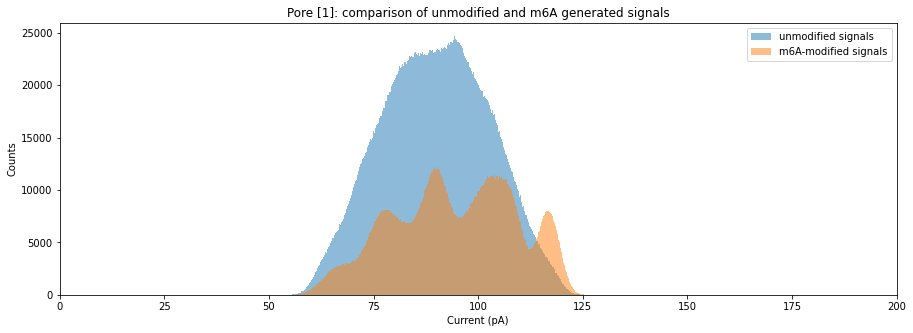

In [19]:
# plot unmodified and m6a-modified signals generated by Pore [1]
plt.figure(figsize=(15, 5))
plt.hist(X_1.iloc[:,0:y_1.count(0)].values.ravel(), bins=500, alpha= 0.5, label="unmodified signals")
plt.hist(X_1.iloc[:,y_1.count(0):].values.ravel(), bins=500, alpha= 0.5, label="m6A-modified signals")
plt.title("Pore [1]: comparison of unmodified and m6A generated signals")
plt.legend()
plt.xlabel("Current (pA)")
plt.ylabel("Counts")
plt.xlim((0, 200))
plt.show()

### 3.2. Generation of the dataset for the second experiment with the pore model [2]

In [20]:
# contains the generated signals. Each column is a read, while rows are ionic currents measurements
X_2 = {} 
# contain unmod/mod class (0: unmodified, 1: modified)
y_2 = []
# contain curlcake class (0, 1, 2, 3)
y_2_curlcake = []

# generate raw signals and y vector of classes for the unmodified reads with the pore [2]
with tqdm(total = (unmod_reads_n*len(unmod_curlcakes)) + (m6A_reads_n*len(m6A_curlcakes))) as pbar:
    for i in range(0, unmod_reads_n):
        for curlcake in range(4):
            unmod_gen_seq = pore2.raw_from_seq(unmod_curlcakes[curlcake])
            y_2.append(0)
            y_2_curlcake.append(curlcake)
            X_2[ curlcake + (len(unmod_curlcakes)*i) ] = unmod_gen_seq
            pbar.update(1)
    
      
    # generate raw signals and y vector of classes for the m6A modified reads with the pore [2] 
    for i in range(unmod_reads_n, unmod_reads_n + m6A_reads_n):
        for curlcake in range(4):         
            m6A_gen_seq = pore2.raw_from_seq(m6A_curlcakes[curlcake])
            y_2.append(1)
            y_2_curlcake.append(curlcake)
            X_2[ curlcake + (len(m6A_curlcakes)*i) ] = m6A_gen_seq
            pbar.update(1)

X_2 = pd.DataFrame.from_dict(X_2, orient='index')
X_2 = X_2.T

100%|██████████| 60/60 [00:51<00:00,  1.17it/s]


In [21]:
print(f"X_2 memory usage: {X_2.memory_usage().sum() / 1024 / 1024} Mb.")

X_2 memory usage: 65.806396484375 Mb.


In [22]:
print("Proportion of unmod/mod classes in all the reads (NanoPore Model [2])")
print(np.unique(np.array( y_2 ), return_counts=True))

Proportion of unmod/mod classes in all the reads (NanoPore Model [2])
(array([0, 1]), array([40, 20]))


In [23]:
print("Curcakes Proportion in all the reads (NanoPore Model [2])")
print(np.unique(np.array( y_2_curlcake ), return_counts=True))

Curcakes Proportion in all the reads (NanoPore Model [2])
(array([0, 1, 2, 3]), array([15, 15, 15, 15]))


In [24]:
print("Curcakes Proportion in Unmodified Reads (NanoPore Model [2])")
print(np.unique(np.array( y_2_curlcake[:y_2.count(0)] ), return_counts=True))
print("Curcakes Proportion in m6A-modified Reads (NanoPore Model [2])")
print(np.unique(np.array( y_2_curlcake[y_2.count(0):] ), return_counts=True))

Curcakes Proportion in Unmodified Reads (NanoPore Model [2])
(array([0, 1, 2, 3]), array([10, 10, 10, 10]))
Curcakes Proportion in m6A-modified Reads (NanoPore Model [2])
(array([0, 1, 2, 3]), array([5, 5, 5, 5]))


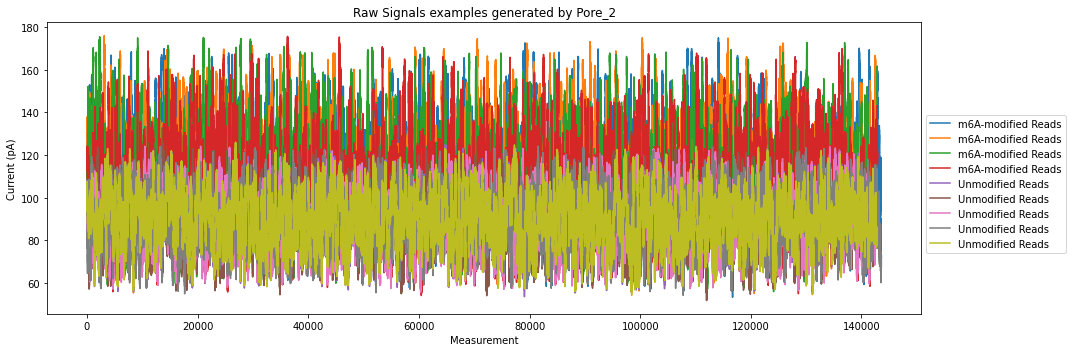

In [25]:
# show a subset of the dataset for the signals generated by the pore [2]
plt.figure(figsize=(15, 5))
plt.plot(X_2.iloc[:, -5:-1], label="m6A-modified Reads")
plt.plot(X_2.iloc[:, 0:5], label="Unmodified Reads")
plt.title("Raw Signals examples generated by Pore_2")
plt.xlabel("Measurement")
plt.ylabel("Current (pA)")
plt.legend(bbox_to_anchor=(1.00, 0.7))
plt.tight_layout()
plt.show()

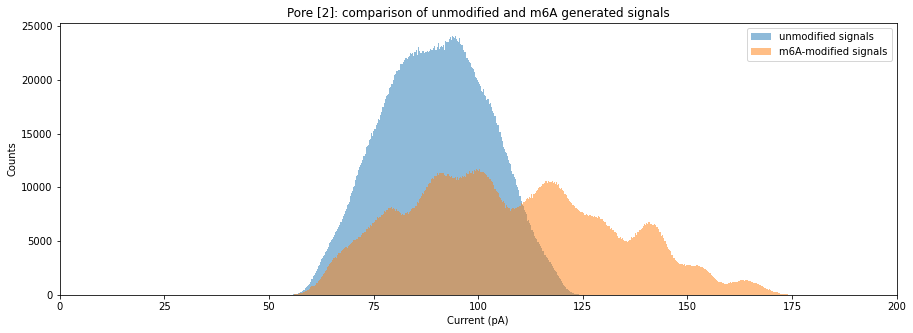

In [26]:
# plot unmodified and m6a-modified signals generated by Pore [2]
plt.figure(figsize=(15, 5))
plt.hist(X_2.iloc[:,0:y_2.count(0)].values.ravel(), bins=500, alpha= 0.5, label="unmodified signals")
plt.hist(X_2.iloc[:,y_2.count(0):].values.ravel(), bins=500, alpha= 0.5, label="m6A-modified signals")
plt.title("Pore [2]: comparison of unmodified and m6A generated signals")
plt.legend()
plt.xlabel("Current (pA)")
plt.ylabel("Counts")
plt.xlim((0, 200))
plt.show()

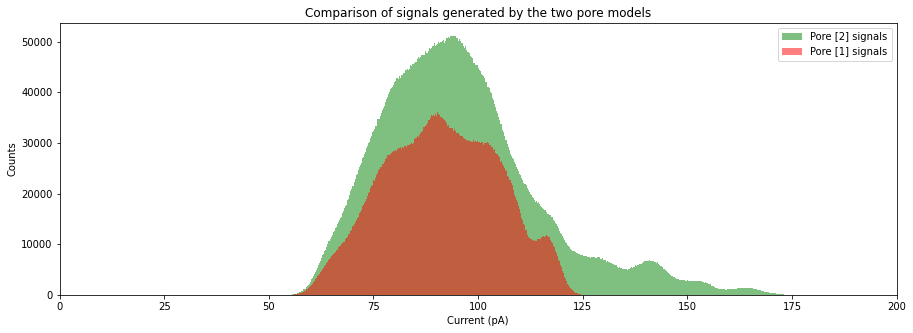

In [27]:
# plot total distributions of signals generatoted by both the pores.
plt.figure(figsize=(15, 5))
plt.hist(X_2.values.ravel(), bins=500, alpha= 0.5, label="Pore [2] signals", color="green")
plt.hist(X_1.values.ravel(), bins=500, alpha= 0.5, label="Pore [1] signals", color="red")
plt.title("Comparison of signals generated by the two pore models")
plt.legend()
plt.xlabel("Current (pA)")
plt.ylabel("Counts")
plt.xlim((0, 200))
plt.show()

### 3.3. Splitting datasets
The next step is to split the dataset of Pore Model [2] into training, validation and test sets in order to obtain, for each pore model, n samples for the training, n samples for the validation and threshold choise (n/2 unmodified and n/2 m6A) and other n samples (n/2 unmodified and n/2 m6A) for the final test and metrics calculation. It is important to be aware that each dataset has the same number of the 4 different starting curlacke sequences.

In [28]:
X_train_signals = X_2.iloc[:, 0 : int(y_2.count(0)/2) ]
X_val_signals = X_2.iloc[:, int(y_2.count(0)/2) : int(y_2.count(0)/2 + y_2.count(0)/4)]
X_test_signals = X_2.iloc[:, int(y_2.count(0)/2 + y_2.count(0)/4) : int(y_2.count(0))]
m6A_train_signals = X_2.iloc[:, int(y_2.count(0)) : int(y_2.count(0)+y_2.count(1)/2)]
m6A_test_signals = X_2.iloc[:, int(y_2.count(0)+y_2.count(1)/2):]

print("X_train_signals shape (measurements, reads)", X_train_signals.shape)
print("X_val_signals shape (measurements, reads)", X_val_signals.shape)
print("X_test_signals shape (measurements, reads)", X_test_signals.shape)
print("m6A_val_signals shape (measurements, reads)", m6A_train_signals.shape)
print("m6A_test_signals shape (measurements, reads)", m6A_test_signals.shape)

X_train_signals shape (measurements, reads) (143756, 20)
X_val_signals shape (measurements, reads) (143756, 10)
X_test_signals shape (measurements, reads) (143756, 10)
m6A_val_signals shape (measurements, reads) (143756, 10)
m6A_test_signals shape (measurements, reads) (143756, 10)


## 4.0. Training of the model

### 4.1. Write Functions to create and reconstruct time-step sequences and MAE error.

In [29]:
# defining model training parameters
TIME_STEPS = 15
n_features = 1
epochs = 100
batch_size = 128

In [30]:
# date to be used to save the model and its histories lists.
date = str(datetime.today()).replace("-", "_").replace(" ", "_").split(".")[0].replace(":", "_")

# set version and date
version = "_v3_0_LSTM_pore_IMPROVED_"

def create_sequences(values, time_steps=TIME_STEPS):
    '''
    Function to create a time_step version of the sequence.
    '''
    output=[]
    for i in range(len(values)+1 - time_steps):
        output.append(values[i:(i+time_steps)])
    return np.stack(output).reshape(len(output), time_steps, 1)

def recostruct_sequence(timestep_sequence):
    '''
    Function to reconstruct the sequence starting
    from the time_step version.
    '''
    output = []
    output += list(timestep_sequence[0].ravel())
    for i in timestep_sequence[1:]:
        output.append( i.ravel()[-1] )
    #output += list(timestep_sequence[-1].ravel())
    output = np.array(output)
    return output

def get_mae(signal, model):
    '''
    Function to get the reconstruction MAE error from a raw signal after the transformation in time_steps
    version and prediction of the reconstructed signal.
    '''
    X_scaled = StandardScaler().fit_transform(signal.dropna().values.reshape(-1,1))
    time_steps = create_sequences(X_scaled)
    time_step_pred = model.predict(time_steps)
    mae_loss = np.mean(np.abs(time_step_pred - time_steps.reshape(time_steps.shape[0], time_steps.shape[1], 1)), axis=1)
    return mae_loss

### 4.1.0. Training of the Model [2]
This model will be trained on signals generated by pore [2] with conversion dictionary 2 ("a" = 170)

In [31]:
# define model
model = Sequential()
# Encoder
model.add(LSTM(128, input_shape=(TIME_STEPS, n_features), return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(RepeatVector(TIME_STEPS))
# Decoder
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
# optimizer and loss function
model.compile(optimizer='adam', loss='mse')
# print summary information
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 128)           66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 15, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 64)            33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 15, 128)           98816     
_________________________________________________________________
time_distributed (TimeDistri (None, 15, 1)             129       
Total params: 247,937
Trainable params: 247,937
Non-trainable params: 0
__________________________________________________

In [32]:
# Prepare a directory to store all the checkpoints and history
checkpoint_dir = os.path.join("./ckpt" + version + date)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
# define the checkpoint
filepath = os.path.join(checkpoint_dir, "model"+version+date+".h5")
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='loss', patience=5)
callbacks_list = [checkpoint, early_stopping]

print(date)
print(version)

2021_03_10_11_13_19
_v3_0_LSTM_pore_IMPROVED_


In [33]:
# define custom function for the training: 
#      1) data generator for the model's training and 
#      2) batches total number calculator 

def dataGenerator(X_train_signals, batch_size):
    '''
    Function produce a generator of batches for the model.fit() method.
    '''
    while True: #generators for keras must be infinite
        for i in X_train_signals.columns:
            X_scaled = StandardScaler().fit_transform(X_train_signals[i].dropna().values.reshape(-1,1)) 
            X_train_time_steps = create_sequences(X_scaled)

            totalSamps = X_train_time_steps.shape[0]
            batches = totalSamps // batch_size

            if totalSamps % batch_size > 0:
                batches+=1

            for batch in range(batches):
                section = slice(batch*batch_size,(batch+1)*batch_size)
                yield (X_train_time_steps[section], X_train_time_steps[section])


def cal_expectedTotalNumberOfYieldsForOneEpoch(X_train_signals, batch_size):
    '''
    Function to calculate total number of generator yealds (batch steps)
    to be considered as one whole epoch by the model.fit() method.
    '''
    expectedTotalNumberOfYieldsForOneEpoch = []
    with tqdm(total=len(X_train_signals.columns)) as pbar:
        for a in X_train_signals.columns:
            X_scaled = StandardScaler().fit_transform(X_train_signals[a].dropna().values.reshape(-1,1))
            X_train_time_steps = create_sequences(X_scaled)
            totalSamps = X_train_time_steps.shape[0]
            batches = totalSamps // batch_size
            if totalSamps % batch_size > 0:
                batches+=1
            expectedTotalNumberOfYieldsForOneEpoch.append(batches)
            pbar.update(1)
    expectedTotalNumberOfYieldsForOneEpoch = np.sum(expectedTotalNumberOfYieldsForOneEpoch)
    return expectedTotalNumberOfYieldsForOneEpoch

In [34]:
# TRAINING OF THE MODEL on unmodified reads of NanoPore Model [2] (that is the same of the model [1] since
# they share the same standard bases contribution).

start_time = datetime.now()
# calculate total batches per epoch
print("Calculating total number of batches per epoch...")
expectedTotalNumberOfYieldsForOneEpoch = cal_expectedTotalNumberOfYieldsForOneEpoch(X_train_signals, batch_size)

# istantiate generator
gen = dataGenerator(X_train_signals, batch_size)

# fit the model with callbacks.
print("Training of the model started:")
history = model.fit(gen,
                    steps_per_epoch = expectedTotalNumberOfYieldsForOneEpoch,
                    epochs = epochs,
                    callbacks=callbacks_list)
end_time = datetime.now()
print("End of Training...")
print(f"Elapsed time: {end_time - start_time}")

  0%|          | 0/20 [00:00<?, ?it/s]

Calculating total number of batches per epoch...


100%|██████████| 20/20 [00:04<00:00,  4.68it/s]


Training of the model started:
Epoch 1/100
22343/22343 [==============================] - 229s 9ms/step - loss: 0.0472

Epoch 00001: loss improved from inf to 0.02852, saving model to ./ckpt_v3_0_LSTM_pore_IMPROVED_2021_03_10_11_13_19/model_v3_0_LSTM_pore_IMPROVED_2021_03_10_11_13_19.h5
Epoch 2/100
22343/22343 [==============================] - 197s 9ms/step - loss: 0.0130

Epoch 00002: loss improved from 0.02852 to 0.01121, saving model to ./ckpt_v3_0_LSTM_pore_IMPROVED_2021_03_10_11_13_19/model_v3_0_LSTM_pore_IMPROVED_2021_03_10_11_13_19.h5
Epoch 3/100
22343/22343 [==============================] - 196s 9ms/step - loss: 0.0065

Epoch 00003: loss improved from 0.01121 to 0.00488, saving model to ./ckpt_v3_0_LSTM_pore_IMPROVED_2021_03_10_11_13_19/model_v3_0_LSTM_pore_IMPROVED_2021_03_10_11_13_19.h5
Epoch 4/100
22343/22343 [==============================] - 196s 9ms/step - loss: 9.0339e-04

Epoch 00004: loss improved from 0.00488 to 0.00086, saving model to ./ckpt_v3_0_LSTM_pore_IMPROVE

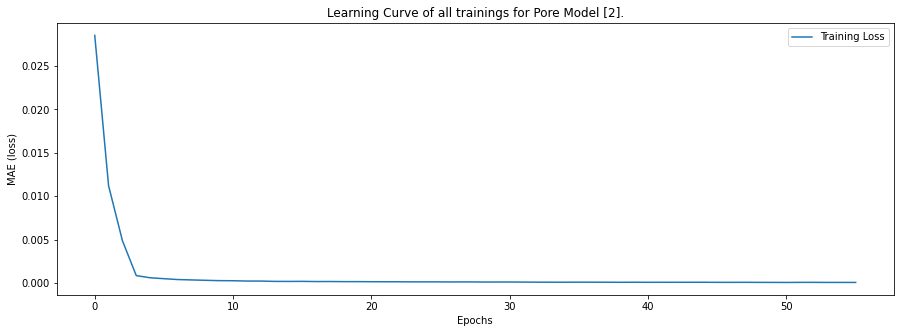

In [35]:
# plot the training and validation losses of all trainings in this session.
plt.figure(figsize=(15,5))
plt.plot(history.history["loss"], label="Training Loss")
plt.title("Learning Curve of all trainings for Pore Model [2].")
plt.xlabel("Epochs")
plt.ylabel("MAE (loss)")
plt.legend()
plt.show()

In [36]:
# load last best model
model = keras.models.load_model(filepath)

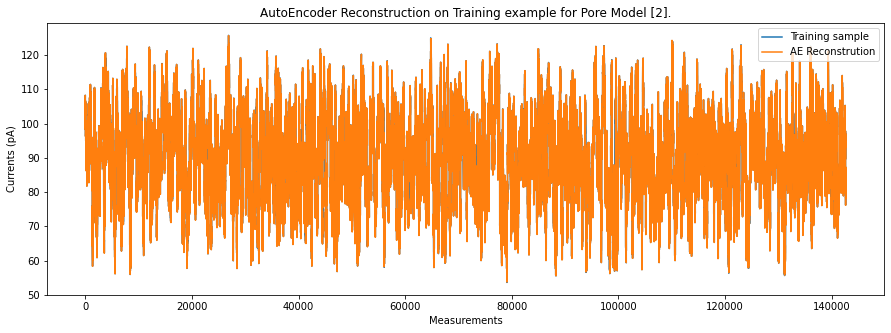

In [37]:
# Visualize reconstructed signal of on a training sample 
sc = StandardScaler()
train_sample = X_train_signals[0].dropna().values.reshape(-1,1)
train_sample_sc = sc.fit_transform(train_sample)
train_sample_time_step = create_sequences(train_sample_sc)
train_sample_pred = model.predict(create_sequences(train_sample_sc))
reconstructed_signal = recostruct_sequence(train_sample_pred)
reconstructed_signal = sc.inverse_transform(reconstructed_signal)

# plot results
plt.figure(figsize=(15,5))
plt.plot(train_sample, label="Training sample")
plt.plot(reconstructed_signal, label="AE Reconstrution")
plt.title("AutoEncoder Reconstruction on Training example for Pore Model [2].")
plt.xlabel("Measurements")
plt.ylabel("Currents (pA)")
plt.legend()
plt.show()

In [38]:
# Getting all the threshold computed for the training samples by the model
thresholds = []
mae_losses = []
with tqdm(total=len(X_train_signals.columns)) as pbar:
    for i in X_train_signals.columns:
        train_mae_loss = get_mae(X_train_signals[i], model)
        mae_losses.append(train_mae_loss)

        # Get reconstruction loss thresholds.
        threshold = np.max(train_mae_loss)
        thresholds.append(threshold)
        pbar.update(1)

100%|██████████| 20/20 [04:54<00:00, 14.73s/it]


In [39]:
threshold_max = round(np.max(thresholds), 2)
print("Mean Threshold +/- S.D. on Training samples:", round(np.mean(thresholds), 2), "+/-", round(np.std(thresholds), 2), "S.D.")
print("Max Value for Threshold in training samples:", threshold_max)

Mean Threshold +/- S.D. on Training samples: 0.02 +/- 0.0 S.D.
Max Value for Threshold in training samples: 0.03


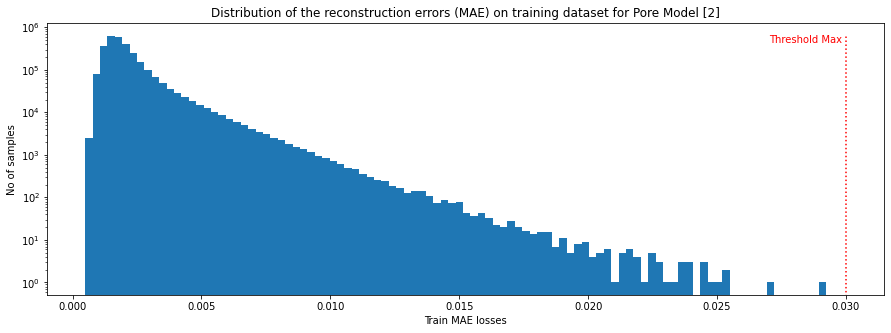

Reconstruction error threshold:  0.03


In [40]:
# plotting MAE reconstruction errors of the training dataset to visualize the maximum threshold.
plt.figure(figsize=(15,5))
plt.hist(np.concatenate(mae_losses), bins=100)
plt.title("Distribution of the reconstruction errors (MAE) on training dataset for Pore Model [2]")
plt.vlines(threshold_max, plt.axis()[2], plt.axis()[3], colors="r", linestyles="dotted")
plt.yscale(value="log")
plt.xlabel("Train MAE losses")
plt.ylabel("No of samples")
plt.text(threshold_max*0.9, plt.axis()[3]*0.35, "Threshold Max", c="r")
plt.show()

print("Reconstruction error threshold: ", threshold_max)

### 4.1.1.  Evaluation of the model [2] on X_val dataset
Now I'd like to see if this threshold works well also on another unmodified read not yet used for the training of the model [2] from the X_val_signals dataframe.

In [41]:
# Getting all the MAE reconstruction errors computed for the validation samples by the model
val_mae_losses = [] # where are stored the mae losses of validation samples.
val_sum_anomalies = [] # where are stored the cumulative number of anomalies per sample.
val_anomaly_indices = [] # where are stored the indices of the anomalies with respect the time_step version of the samples
with tqdm(total=len(X_val_signals.columns)) as pbar:
    for i in X_val_signals.columns:
        val_mae_loss = get_mae(X_val_signals[i], model)
        val_mae_losses.append(val_mae_loss)
        anomalies = val_mae_loss > threshold_max
        sum_anomalies = np.sum(anomalies)
        anomalies_indices = np.where(anomalies)
        val_sum_anomalies.append(sum_anomalies)
        val_anomaly_indices.append(anomalies_indices)

        pbar.update(1)

100%|██████████| 10/10 [02:29<00:00, 14.94s/it]


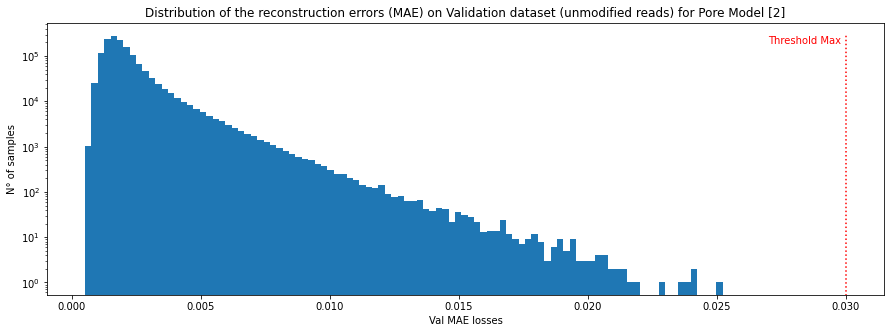

Number of anomaly samples in validation reads: 0


In [42]:
# plotting MAE reconstruction errors of the validation dataset.
plt.figure(figsize=(15,5))
plt.hist(np.concatenate(val_mae_losses), bins=100)
plt.title("Distribution of the reconstruction errors (MAE) on Validation dataset (unmodified reads) for Pore Model [2]")
plt.vlines(threshold_max, plt.axis()[2], plt.axis()[3], colors="r", linestyles="dotted")
plt.yscale(value="log")
plt.xlabel("Val MAE losses")
plt.ylabel("N° of samples")
plt.text(threshold_max*0.9, plt.axis()[3]*0.35, "Threshold Max", c="r")
plt.show()

print("Number of anomaly samples in validation reads:", np.sum(val_sum_anomalies))

### 4.1.1.  Evaluation of the model [2] on m6A_train dataset

In [43]:
# Getting all the MAE reconstruction errors computed for the m6A training samples by the model

m6A_train_mae_losses = [] # where are stored the mae losses of m6A training samples.
m6A_train_sum_anomalies = [] # where are stored the cumulative number of anomalies per sample.
m6A_train_anomaly_indices = [] # where are stored the indices of the anomalies with respect the time_step version of the samples
with tqdm(total=len(m6A_train_signals.columns)) as pbar:
    for i in m6A_train_signals.columns:
        m6A_train_mae_loss = get_mae(m6A_train_signals[i], model)
        m6A_train_mae_losses.append(m6A_train_mae_loss)
        anomalies = m6A_train_mae_loss > threshold_max
        sum_anomalies = np.sum(anomalies)
        anomalies_indices = np.where(anomalies)
        m6A_train_sum_anomalies.append(sum_anomalies)
        m6A_train_anomaly_indices.append(anomalies_indices)

        pbar.update(1)

100%|██████████| 10/10 [02:31<00:00, 15.11s/it]


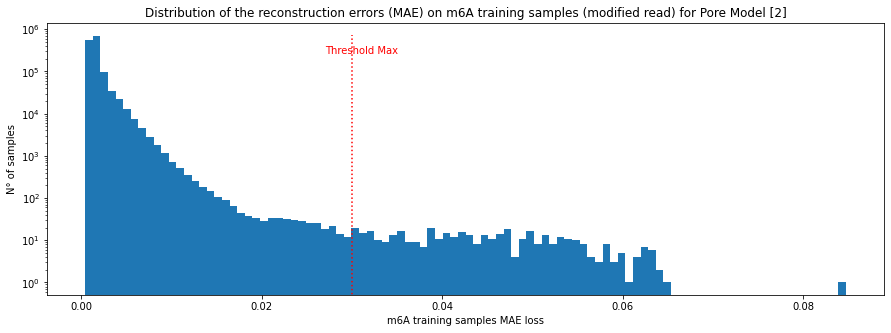

Number of anomaly samples: 422


In [44]:
# plotting MAE reconstruction errors of the m6A_train dataset for the model.
plt.figure(figsize=(15,5))
plt.hist(np.concatenate(m6A_train_mae_losses), bins=100)
plt.title("Distribution of the reconstruction errors (MAE) on m6A training samples (modified read) for Pore Model [2]")
plt.vlines(threshold_max, plt.axis()[2], plt.axis()[3], colors="r", linestyles="dotted")
plt.text(threshold_max*0.9, plt.axis()[3]*0.35, "Threshold Max", c="r")
plt.yscale(value="log")
plt.xlabel("m6A training samples MAE loss")
plt.ylabel("N° of samples")
plt.show()

anomalies_m6A_train = np.concatenate(m6A_train_mae_losses) > threshold_max
print("Number of anomaly samples:", np.sum(anomalies_m6A_train))

### 4.1.2. Best Threshold Choise for Model [2]

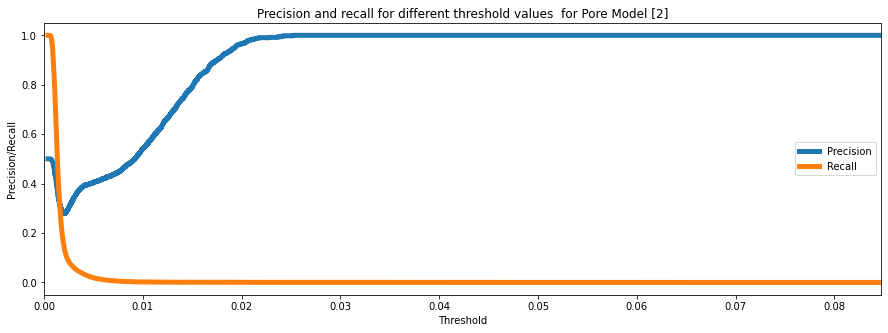

In [45]:
y_m6A_train = np.array([1 for i in np.concatenate(m6A_train_mae_losses)]) # real class vector for m6A_train
y_unmod_val = np.array([0 for i in np.concatenate(val_mae_losses)]) # real class vector for X_val unmodifed reads
# concatenate both of them into single vector
mse_total_val = np.concatenate([np.concatenate(m6A_train_mae_losses), np.concatenate(val_mae_losses)]) 
# concatenate also class labels into a single vector
y_total_val = np.concatenate([y_m6A_train, y_unmod_val]) 

# calculating precision/reacall scores over the threshold values
precision_rt, recall_rt, threshold_rt = precision_recall_curve(y_total_val, mse_total_val)

# producing precision/recall vs threshold curves
plt.figure(figsize=(15,5))
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values  for Pore Model [2]')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.xlim(0, threshold_rt.max())
plt.legend()
plt.show()

Obviously, since the classes have been assigned in a not-common manner, with m6A modified reads containing also normal events and bases, the Precision/Recall vs threshold curves are not easily interpretable. Anyway they give some information about the behaviour of the model. It's better to use these information together with another way to see the problem that is the number of anomalies found in unmodified and m6A-modified reads by the variation of the threshold value on the validations sets as following:

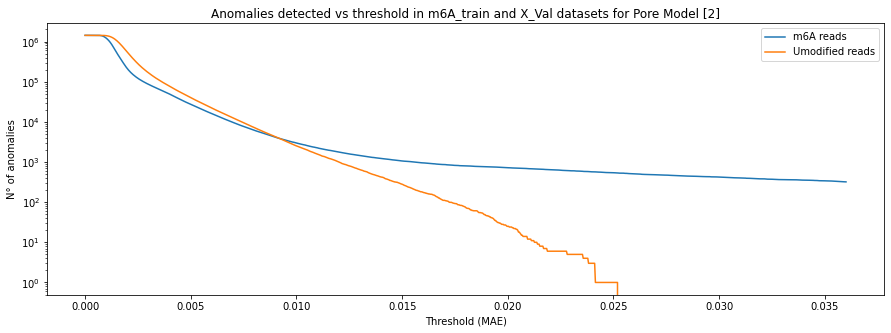

In [46]:
# evaluate how the number of detected anomalies changes in both 
# m6A_train and unmodified X_val samples in function of the threshold value.
trs = []
m6A_over_t = []
unmod_over_t =[]
for t in np.linspace(0, threshold_max*1.20, 1000):
    trs.append(t)
    m6A_over_t.append(np.sum(np.concatenate(m6A_train_mae_losses) > t))
    unmod_over_t.append(np.sum(np.concatenate(val_mae_losses) > t))

plt.figure(figsize=(15,5))
plt.plot(trs, m6A_over_t, label="m6A reads")
plt.plot(trs, unmod_over_t, label="Umodified reads")
plt.xlabel("Threshold (MAE)")
plt.ylabel("N° of anomalies")
plt.yscale("log")
plt.title("Anomalies detected vs threshold in m6A_train and X_Val datasets for Pore Model [2]")
plt.legend()
plt.show()

In [47]:
# Detecting a good threshold as the minimum threshold value with 0 anomalies in unmodified reads
min_value_umod_anom = np.min(np.array(unmod_over_t))
min_index_unmod = np.min(np.argwhere(np.array(unmod_over_t) == min_value_umod_anom)) # first index where no anomalies are detected in unmodified data
new_threshold = trs[min_index_unmod] # threshold with 0 anomalies in unmodified reads
print("Best Threshold is:", new_threshold)

Best Threshold is: 0.02522522522522522


A good threshold seems to be: 0.02522522522522522 MAE

Number of anomalies in m6A_train samples: 532
Percentage of anomalies in modified m6A_train dataset on total measurements evaluated: 0.03723 %

Number of anomalies in X_val samples: 0
Percentage of anomalies in unmodified X_val dataset on total measurements evaluated: 0.0 %

m6A_train/X_val anomalies ratio inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


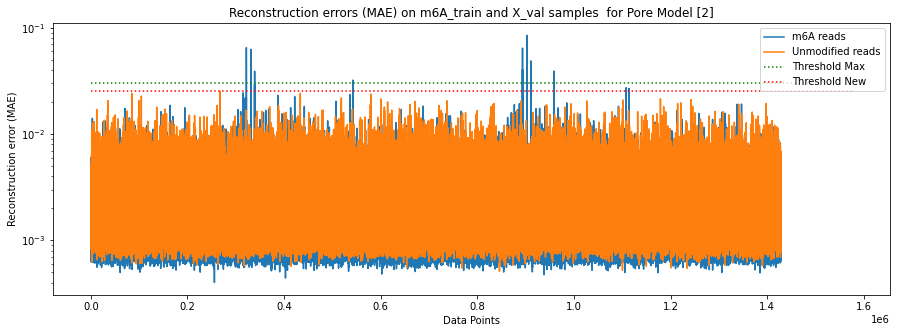

In [48]:
# Visualize results on Validation sets with the new best threshold and the old one computed on the training dataset.
print(f"A good threshold seems to be: {new_threshold} MAE\n")

# Results on m6A_train and X_val datasets:
print("Number of anomalies in m6A_train samples:", np.sum(np.concatenate(m6A_train_mae_losses) > new_threshold))
print("Percentage of anomalies in modified m6A_train dataset on total measurements evaluated:", round(np.sum(np.concatenate(m6A_train_mae_losses) > new_threshold) / np.concatenate(m6A_train_mae_losses).shape[0] * 100, 5), "%\n" )
print("Number of anomalies in X_val samples:", np.sum(np.concatenate(val_mae_losses) > new_threshold))
print("Percentage of anomalies in unmodified X_val dataset on total measurements evaluated:", round(np.sum(np.concatenate(val_mae_losses) > new_threshold) / np.concatenate(val_mae_losses).shape[0] * 100, 5), "%\n" )
print("m6A_train/X_val anomalies ratio", 
        np.sum(np.concatenate(m6A_train_mae_losses) > new_threshold) / 
        np.sum(np.concatenate(val_mae_losses) > new_threshold))

# Compare the Reconstruction MAE of the model in both the datasets with respect the new and max_threshold values
# computed in the training dataset.
plt.figure(figsize=(15,5))
plt.title("Reconstruction errors (MAE) on m6A_train and X_val samples  for Pore Model [2]")
plt.plot(np.concatenate(m6A_train_mae_losses), label="m6A reads", zorder=0)
plt.plot(np.concatenate(val_mae_losses), label="Unmodified reads", zorder=1)
plt.yscale(value="log")
plt.xlabel("Data Points")
plt.ylabel("Reconstruction error (MAE)")
plt.hlines(threshold_max, -1, plt.axis()[1], colors="g", linestyles="dotted", label="Threshold Max", zorder=3)
plt.hlines(new_threshold, -1, plt.axis()[1], colors="r", linestyles="dotted", label="Threshold New", zorder=4)
plt.legend()
plt.show()

### 4.1.3. Evaluation on test sets

In [49]:
# Getting all the MAE reconstruction errors computed for the test samples by the model
test_mae_losses = [] # where are stored the mae losses of test samples.
test_sum_anomalies = [] # where are stored the cumulative number of anomalies per sample.
test_anomaly_indices = [] # where are stored the indices of the anomalies with respect the time_step version of the samples
with tqdm(total=len(X_test_signals.columns)) as pbar:
    for i in X_test_signals.columns:
        test_mae_loss = get_mae(X_test_signals[i], model)
        test_mae_losses.append(test_mae_loss)
        anomalies = test_mae_loss > new_threshold
        sum_anomalies = np.sum(anomalies)
        anomalies_indices = np.where(anomalies)
        test_sum_anomalies.append(sum_anomalies)
        test_anomaly_indices.append(anomalies_indices)

        pbar.update(1)

100%|██████████| 10/10 [02:31<00:00, 15.14s/it]


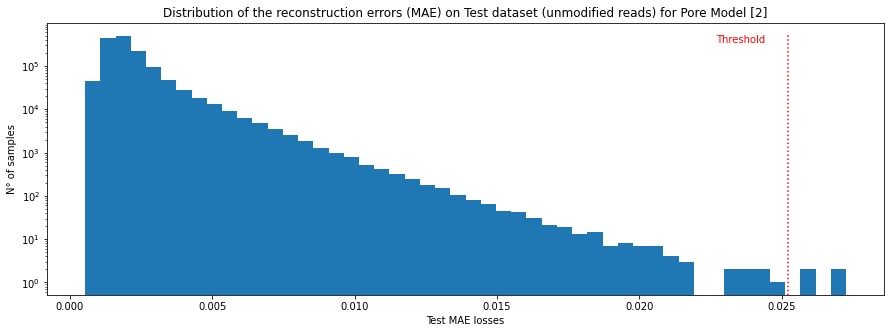

Number of anomaly samples in test reads: 4


In [50]:
# plotting MAE reconstruction errors of the test dataset.
plt.figure(figsize=(15,5))
plt.hist(np.concatenate(test_mae_losses), bins=50)
plt.title("Distribution of the reconstruction errors (MAE) on Test dataset (unmodified reads) for Pore Model [2]")
plt.vlines(new_threshold, plt.axis()[2], plt.axis()[3], colors="r", linestyles="dotted")
plt.yscale(value="log")
plt.xlabel("Test MAE losses")
plt.ylabel("N° of samples")
plt.text(new_threshold*0.9, plt.axis()[3]*0.35, "Threshold", c="r")
plt.show()
print("Number of anomaly samples in test reads:", np.sum(test_sum_anomalies))

In [51]:
# Getting all the MAE reconstruction errors computed for the m6A test samples by the model
m6A_test_mae_losses = [] # where are stored the mae losses of m6A test samples.
m6A_test_sum_anomalies = [] # where are stored the cumulative number of anomalies per sample.
m6A_test_anomaly_indices = [] # where are stored the indices of the anomalies with respect the time_step version of the samples
with tqdm(total=len(m6A_test_signals.columns)) as pbar:
    for i in m6A_test_signals.columns:
        m6A_test_mae_loss = get_mae(m6A_test_signals[i], model)
        m6A_test_mae_losses.append(m6A_test_mae_loss)
        anomalies = m6A_test_mae_loss > new_threshold
        sum_anomalies = np.sum(anomalies)
        anomalies_indices = np.where(anomalies)
        m6A_test_sum_anomalies.append(sum_anomalies)
        m6A_test_anomaly_indices.append(anomalies_indices)

        pbar.update(1)

100%|██████████| 10/10 [02:29<00:00, 14.93s/it]


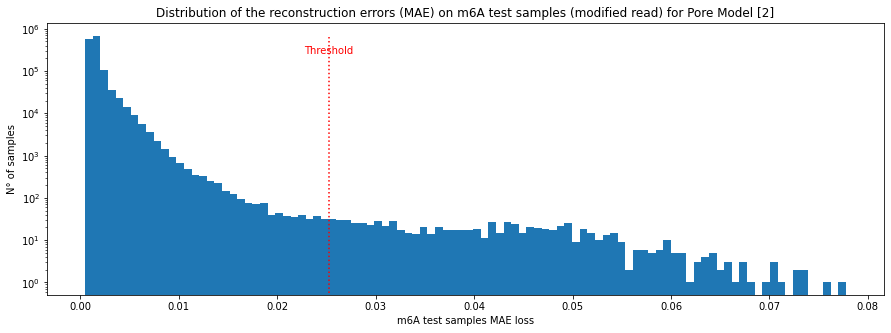

Number of anomaly samples in m6A test reads: 837


In [52]:
# plotting MAE reconstruction errors of the m6A_test dataset for the model
plt.figure(figsize=(15,5))
plt.hist(np.concatenate(m6A_test_mae_losses), bins=100)
plt.title("Distribution of the reconstruction errors (MAE) on m6A test samples (modified read) for Pore Model [2]")
plt.vlines(new_threshold, plt.axis()[2], plt.axis()[3], colors="r", linestyles="dotted")
plt.text(new_threshold*0.9, plt.axis()[3]*0.35, "Threshold", c="r")
plt.yscale(value="log")
plt.xlabel("m6A test samples MAE loss")
plt.ylabel("N° of samples")
plt.show()

anomalies_m6A_test = np.concatenate(m6A_test_mae_losses) > new_threshold
print("Number of anomaly samples in m6A test reads:", np.sum(m6A_test_sum_anomalies))

Number of anomalies in m6A_test samples: 837
Percentage of anomalies in m6A_test dataset on total measurements evaluated: 0.05853 %

Number of anomalies in X_test samples: 4
Percentage of anomalies in unmodified X_test dataset on total measurements evaluated: 0.00028 %

m6A_test/X_test anomalies ratio 209.25


/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


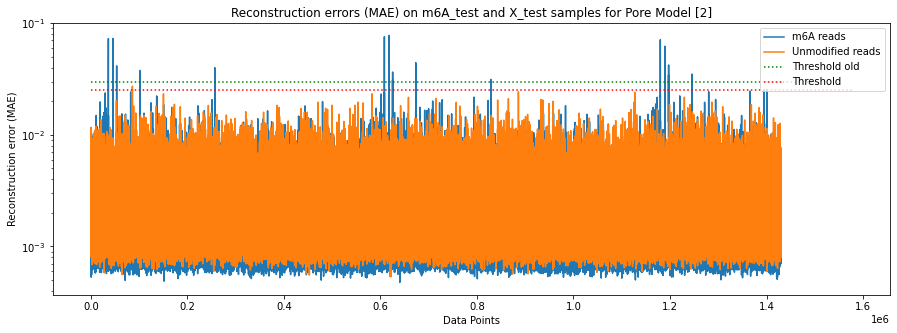

In [53]:
# Results on m6A_test and X_test datasets:
print("Number of anomalies in m6A_test samples:", np.sum(np.concatenate(m6A_test_mae_losses) > new_threshold))
print("Percentage of anomalies in m6A_test dataset on total measurements evaluated:", round(np.sum(np.concatenate(m6A_test_mae_losses) > new_threshold) / np.concatenate(m6A_test_mae_losses).shape[0] * 100, 5), "%\n" )
print("Number of anomalies in X_test samples:", np.sum(np.concatenate(test_mae_losses) > new_threshold))
print("Percentage of anomalies in unmodified X_test dataset on total measurements evaluated:", round(np.sum(np.concatenate(test_mae_losses) > new_threshold) / np.concatenate(test_mae_losses).shape[0] * 100, 5), "%\n" )
print("m6A_test/X_test anomalies ratio", 
        np.sum(np.concatenate(m6A_test_mae_losses) > new_threshold) / 
        np.sum(np.concatenate(test_mae_losses) > new_threshold))

# Compare the Reconstruction MAE of the model in both the datasets with respect the max_threshold value
# computed in the training dataset.
plt.figure(figsize=(15,5))
plt.title("Reconstruction errors (MAE) on m6A_test and X_test samples for Pore Model [2]")
plt.plot(np.concatenate(m6A_test_mae_losses), label="m6A reads", zorder=0)
plt.plot(np.concatenate(test_mae_losses), label="Unmodified reads", zorder=1)
plt.yscale(value="log")
plt.xlabel("Data Points")
plt.ylabel("Reconstruction error (MAE)")
plt.hlines(threshold_max, -1, plt.axis()[1], colors="g", linestyles="dotted", label="Threshold old", zorder=3)
plt.hlines(new_threshold, -1, plt.axis()[1], colors="r", linestyles="dotted", label="Threshold", zorder=4)
plt.legend()
plt.show()

## 4.2. Evaluation on unmodified and modified reads produced by Pore Model [1] 
The NanoPore Model [1] produce signal basing on the conversion dictionary with signal of the "a" modified base equal to 118 pA, very similar to those generate by C base.

In [54]:
# dataset produced by Pore Model [1]
X_1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,106.057325,99.127198,88.178213,97.213788,101.299165,98.747690,87.925879,95.714246,103.942505,99.538960,84.639291,96.045802,101.752718,99.863293,86.979342,97.349671,103.195383,98.872108,82.241749,96.834773,109.908636,96.086375,89.734911,95.400041,103.382173,97.517590,87.363064,98.040625,104.308803,99.111401,86.264514,98.851712,102.805760,100.561774,84.950582,98.750483,100.960588,94.729023,87.164972,98.213841,106.268781,104.057873,93.433025,105.856481,108.893023,102.988737,91.525552,105.440308,109.309795,103.883187,95.289847,105.791017,110.163301,101.093343,93.726283,104.934478,107.066913,106.087000,95.026254,105.357169
1,105.338240,99.366623,85.308330,95.639475,102.233912,98.727762,88.720050,96.372607,106.118948,98.074809,87.731139,97.782317,104.647306,100.457461,83.254714,96.337846,101.756366,97.617566,87.564208,97.083670,103.900699,100.454418,87.864059,96.618257,104.123308,100.585246,86.028372,98.575056,105.435775,96.991921,85.290367,96.020307,101.608378,100.332451,87.492359,95.683120,101.104904,98.848840,83.865940,95.855802,107.704976,105.280674,94.953462,105.319516,107.934582,104.463535,95.839517,105.787808,109.332225,103.626370,96.556281,106.622779,108.122864,107.434077,93.280442,105.972339,108.978801,103.069821,95.737600,103.905040
2,103.678737,96.266850,89.075844,95.484412,101.717431,96.570796,87.220935,96.718968,103.127087,97.692389,88.038409,100.016145,102.548704,101.604768,87.775653,95.833770,104.849510,99.840423,85.718259,97.348217,102.879324,100.473653,84.546246,101.024341,107.378082,100.517755,87.079373,99.435589,103.619813,100.890238,89.915653,96.854309,103.839804,98.696471,88.877871,96.129664,102.005628,98.267981,91.290209,97.908633,109.253945,102.979370,95.920441,102.146031,108.230191,101.867651,95.555935,106.544922,106.550097,107.881290,94.757939,107.121714,108.757468,101.323463,94.847133,101.911610,109.385581,104.737875,97.788530,101.268748
3,106.175114,105.401053,87.410175,96.693680,103.537437,100.552554,84.140062,97.885549,100.266339,96.614636,86.248087,98.702160,99.859376,96.947133,87.501270,97.425463,104.126181,95.792737,90.139921,96.312476,103.276687,99.078462,86.129488,97.867242,101.924900,99.663636,84.637697,97.327141,101.715869,99.202759,86.973531,97.157299,101.707649,100.888068,86.724062,95.632781,102.220706,99.767758,84.823734,100.616711,106.780396,101.021009,95.525698,106.656503,109.743794,103.781398,96.094687,106.815507,111.356011,106.478288,94.169691,104.880668,108.157386,102.416053,95.402049,101.635446,107.856083,107.617780,95.729282,103.435413
4,105.682827,97.432207,87.385463,94.990521,105.175636,99.443703,90.990747,96.856327,105.747443,98.381529,88.284621,95.986917,104.933224,94.796583,86.100373,90.400652,105.398187,96.459502,86.012212,95.553456,101.743982,98.555802,87.461394,93.987098,104.607828,97.155661,83.490175,96.082803,103.480901,98.140306,86.873805,99.098408,104.908320,101.117808,84.520958,96.458194,102.354336,96.842428,88.176293,94.911703,105.802177,103.932180,95.074706,104.714204,108.996398,101.318474,91.638328,107.886648,106.860708,102.499126,92.738741,104.081033,107.766237,99.105827,95.099528,105.041127,107.510988,105.639744,94.070550,105.754881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.564110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.503818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [55]:
# extracting only reads produced by NanoPore Model [1] from m6A reads.
m6A_pore_1_index = np.argwhere(np.array(y_1) == 1).ravel()
m6A_pore_1_index

array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59])

In [56]:
m6A_test_signals = X_1.iloc[:, m6A_pore_1_index]

print("m6A_test_signals shape (measurements, reads)", m6A_test_signals.shape)

m6A_test_signals shape (measurements, reads) (143725, 20)


In [57]:
m6A_test_signals

,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,106.268781,104.057873,93.433025,105.856481,108.893023,102.988737,91.525552,105.440308,109.309795,103.883187,95.289847,105.791017,110.163301,101.093343,93.726283,104.934478,107.066913,106.087000,95.026254,105.357169
1,107.704976,105.280674,94.953462,105.319516,107.934582,104.463535,95.839517,105.787808,109.332225,103.626370,96.556281,106.622779,108.122864,107.434077,93.280442,105.972339,108.978801,103.069821,95.737600,103.905040
2,109.253945,102.979370,95.920441,102.146031,108.230191,101.867651,95.555935,106.544922,106.550097,107.881290,94.757939,107.121714,108.757468,101.323463,94.847133,101.911610,109.385581,104.737875,97.788530,101.268748
3,106.780396,101.021009,95.525698,106.656503,109.743794,103.781398,96.094687,106.815507,111.356011,106.478288,94.169691,104.880668,108.157386,102.416053,95.402049,101.635446,107.856083,107.617780,95.729282,103.435413
4,105.802177,103.932180,95.074706,104.714204,108.996398,101.318474,91.638328,107.886648,106.860708,102.499126,92.738741,104.081033,107.766237,99.105827,95.099528,105.041127,107.510988,105.639744,94.070550,105.754881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
# get total number of anomalies detected by the model on the m6A_test_signal dataset generated 
# by the Pore Model [1] with current of base "a" equal to 118 pA (very similar to C base, 120 pA).
m6A_test_mae_losses_pore1 = []
with tqdm(total=len(m6A_test_signals.columns)) as pbar:
    for i in m6A_test_signals.columns:
        m6A_test_mae_loss = get_mae(m6A_test_signals[i], model)
        m6A_test_mae_losses_pore1.append(m6A_test_mae_loss)
        pbar.update(1)

100%|██████████| 20/20 [05:05<00:00, 15.28s/it]


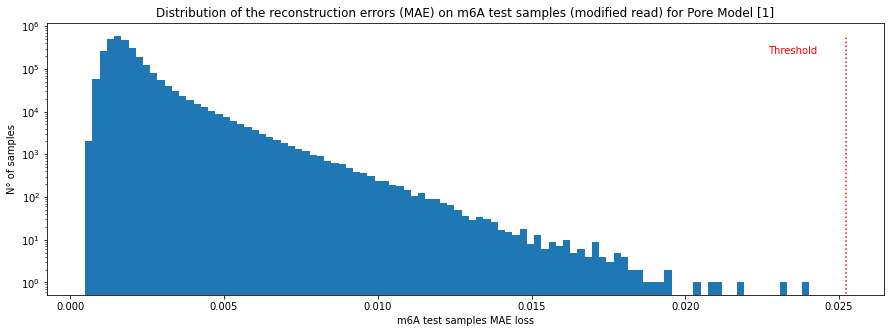

Number of anomaly samples in m6A test reads for Pore Model [1]: 0


In [59]:
# plotting MAE reconstruction errors of the m6A_test dataset generate by the NanoPore model [1]
plt.figure(figsize=(15,5))
plt.hist(np.concatenate(m6A_test_mae_losses_pore1), bins=100)
plt.title("Distribution of the reconstruction errors (MAE) on m6A test samples (modified read) for Pore Model [1]")
plt.vlines(new_threshold, plt.axis()[2], plt.axis()[3], colors="r", linestyles="dotted")
plt.text(new_threshold*0.9, plt.axis()[3]*0.35, "Threshold", c="r")
plt.yscale(value="log")
plt.xlabel("m6A test samples MAE loss")
plt.ylabel("N° of samples")
plt.show()
print("Number of anomaly samples in m6A test reads for Pore Model [1]:", np.sum(np.concatenate(m6A_test_mae_losses_pore1) > new_threshold) )